## Import libraries

In [1]:
import pandas as pd
from ast import literal_eval
import string
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer

In [2]:
tsd_train = pd.read_csv('data/tsd_train.csv')
tsd_test = pd.read_csv('data/tsd_test.csv')
tsd_trial = pd.read_csv('data/tsd_trial.csv')

tsd_train['spans'] = tsd_train['spans'].apply(literal_eval)
tsd_test['spans'] = tsd_test['spans'].apply(literal_eval)
tsd_trial['spans'] = tsd_trial['spans'].apply(literal_eval)

tsd_train.head(10)

,spans,text
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",Another violent and aggressive immigrant killi...
1,"[33, 34, 35, 36, 37, 38, 39]","I am 56 years old, I am not your fucking junio..."
2,"[0, 1, 2, 3]","Damn, a whole family. Sad indeed."
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",What a knucklehead. How can anyone not know th...
4,"[32, 33, 34, 35, 36, 37, 38]","""who do you think should do the killing?""\n\nA..."
5,[],"But, but, but, is NOT a defense. It's not eve..."
6,"[39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 5...","Please people, stop using these silly, stupid ..."
7,"[0, 1, 2, 3]",Dumb.
8,"[49, 50, 51, 52, 53, 54, 147, 148, 149, 150, 1...",Obamacare is on it's last gasping breaths. Y...
9,"[32, 33, 34, 35, 36, 37, 38, 39]",CROOKED Trump = GUILTY as hell.\npathetic


## Data preprocessing

In [3]:
# Lowercase all characters
tsd_train['text'] = tsd_train['text'].apply(lambda x: x.lower())
tsd_test['text'] = tsd_test['text'].apply(lambda x: x.lower())
tsd_trial['text'] = tsd_trial['text'].apply(lambda x: x.lower())

# Replace \n by space, so the index won't be effected
# Replace emojis by ?
tsd_train['text'] = tsd_train['text'].apply(lambda x: x.replace('\n', ' '))
tsd_train['text'] = tsd_train['text'].apply(lambda x: x.encode('ascii', 'replace').decode('ascii'))

tsd_test['text'] = tsd_test['text'].apply(lambda x: x.replace('\n', ' '))
tsd_test['text'] = tsd_test['text'].apply(lambda x: x.encode('ascii', 'replace').decode('ascii'))

tsd_trial['text'] = tsd_trial['text'].apply(lambda x: x.replace('\n', ' '))
tsd_trial['text'] = tsd_trial['text'].apply(lambda x: x.encode('ascii', 'replace').decode('ascii'))

# Remove punctuations
def remove_punctuation(text):
    punctuationfree = []
    for i in text:
        if i not in string.punctuation:
            punctuationfree.append(i)
        else:
            punctuationfree.append(' '*len(i))
    if punctuationfree[-1] == ' ':
        punctuationfree = punctuationfree[:-1]
    punctuationfree = ''.join(punctuationfree)
    return punctuationfree

tsd_train['text'] = tsd_train['text'].apply(lambda x: remove_punctuation(x))
tsd_trial['text'] = tsd_trial['text'].apply(lambda x: remove_punctuation(x))
tsd_test['text'] = tsd_test['text'].apply(lambda x: remove_punctuation(x))

tsd_train.head(10)

,spans,text
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",another violent and aggressive immigrant killi...
1,"[33, 34, 35, 36, 37, 38, 39]",i am 56 years old i am not your fucking junio...
2,"[0, 1, 2, 3]",damn a whole family sad indeed
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",what a knucklehead how can anyone not know th...
4,"[32, 33, 34, 35, 36, 37, 38]",who do you think should do the killing any...
5,[],but but but is not a defense it s not eve...
6,"[39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 5...",please people stop using these silly stupid ...
7,"[0, 1, 2, 3]",dumb
8,"[49, 50, 51, 52, 53, 54, 147, 148, 149, 150, 1...",obamacare is on it s last gasping breaths y...
9,"[32, 33, 34, 35, 36, 37, 38, 39]",crooked trump guilty as hell pathetic


## Transform data

BIO tagging and find span for each word

In [4]:
def find_toxic_words(span, text):
    i = 0
    token = []
    a = 0

    word = []

    while (i < (len(span) - 1)):
        if (span[i] != (span[i+1]-1)):
            token.append(span[a:(i+1)])
            a = i + 1
        elif i == (len(span) - 2):
            token.append(span[a:i+2])

        i = i + 1

    for t in token:
        word.append(text[t[0]:(t[len(t)-1])+1])

    return word

def BIO_tagger(span, text, get_span=0):
    tknzr2 = TweetTokenizer()
    tmp_tokens = tknzr2.tokenize(text)
    tokens = []
    token_span = []
    for each_token in tmp_tokens:
        if each_token not in string.punctuation:
            tokens.append(each_token)
            if get_span == 1:
                if len(token_span) != 0:
                    tmp = text[token_span[len(token_span)-1][-1]+1:]
                    start = tmp.find(each_token) + token_span[len(token_span)-1][-1]+1
                    token_span.append(list(range(start, start + len(each_token))))
                else:
                    token_span.append(list(range(0, len(each_token))))

    sequence = []
    for each in tokens:
        sequence.append([each, 'O'])

    toxic_words = find_toxic_words(span, text)

    toxic_tokens = []
    for i in range(0, len(tokens)):
        for each_toxic in toxic_words:
            t = tknzr2.tokenize(each_toxic)
            if tokens[i] in t:
                if tokens[i] == t[0]:
                    sequence[i][1] = 'B'
                elif i != 0 and (sequence[i-1][1] == 'B' or sequence[i-1][1] == 'I'):
                    sequence[i][1] = 'I'

    return sequence, toxic_words, token_span

# Build a new dataframe to store tokens and tags
def encode(df, get_span=0):
    result_sequence  = []
    result_toxic_words = []
    result_token_span = []

    for index, row in df.iterrows():
        sequence, toxic_words, token_span = BIO_tagger(row['spans'], row['text'], get_span)
        result_sequence.append(sequence)
        result_toxic_words.append(toxic_words)
        result_token_span.append(token_span)

    df['sequence'] = result_sequence
    df['toxic_word'] = result_toxic_words
    if get_span == 1:
        df['token_span'] = result_token_span

encode(tsd_train)
encode(tsd_trial)
encode(tsd_test, 1)

tsd_train.head(10)

,spans,text,sequence,toxic_word
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",another violent and aggressive immigrant killi...,"[[another, O], [violent, B], [and, I], [aggres...",[violent and aggressive immigrant]
1,"[33, 34, 35, 36, 37, 38, 39]",i am 56 years old i am not your fucking junio...,"[[i, O], [am, O], [56, O], [years, O], [old, O...",[fucking]
2,"[0, 1, 2, 3]",damn a whole family sad indeed,"[[damn, B], [a, O], [whole, O], [family, O], [...",[damn]
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",what a knucklehead how can anyone not know th...,"[[what, O], [a, O], [knucklehead, B], [how, O]...",[knucklehead]
4,"[32, 33, 34, 35, 36, 37, 38]",who do you think should do the killing any...,"[[who, O], [do, O], [you, O], [think, O], [sho...",[killing]
5,[],but but but is not a defense it s not eve...,"[[but, O], [but, O], [but, O], [is, O], [not, ...",[]
6,"[39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 5...",please people stop using these silly stupid ...,"[[please, O], [people, O], [stop, O], [using, ...","[stupid, emoticons]"
7,"[0, 1, 2, 3]",dumb,"[[dumb, B]]",[dumb]
8,"[49, 50, 51, 52, 53, 54, 147, 148, 149, 150, 1...",obamacare is on it s last gasping breaths y...,"[[obamacare, O], [is, O], [on, O], [it, O], [s...","[idiots, stupid]"
9,"[32, 33, 34, 35, 36, 37, 38, 39]",crooked trump guilty as hell pathetic,"[[crooked, O], [trump, O], [guilty, O], [as, O...",[pathetic]


## Visualize number of toxic spans in each comment

In [6]:
len_toxic_words = tsd_train['toxic_word'].apply(len)
len_toxic_words.value_counts(normalize=True, sort=True)

1     0.676534
2     0.200655
0     0.061091
3     0.043330
4     0.011588
5     0.003401
6     0.001512
7     0.001008
8     0.000504
25    0.000126
9     0.000126
11    0.000126
Name: toxic_word, dtype: float64

Text(0, 0.5, 'Number of comments')

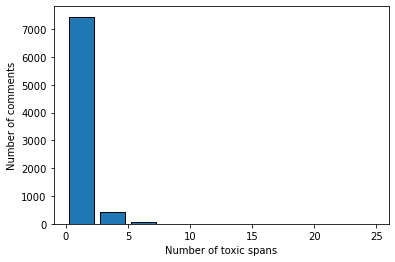

In [7]:
%matplotlib inline

fig, ax = plt.subplots()
ax.hist(len_toxic_words, density=False, edgecolor='k', rwidth=0.8)  # density=False would make counts

plt.xlabel('Number of toxic spans')
plt.ylabel('Number of comments')

## Visualize the number of tokens in each comment

In [8]:
len_comment = tsd_train['sequence'].apply(len)
len_comment.value_counts(normalize=True, sort=True)

9      0.027837
14     0.026200
12     0.025822
17     0.025318
10     0.025192
         ...   
197    0.000126
194    0.000126
202    0.000126
189    0.000126
152    0.000126
Name: sequence, Length: 198, dtype: float64

Text(0, 0.5, 'Number of comments')

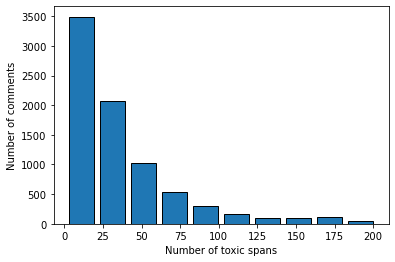

In [10]:
%matplotlib inline

fig, ax = plt.subplots()
ax.hist(len_comment, density=False, edgecolor='k', rwidth=0.8)  # density=False would make counts

plt.xlabel('Number of toxic spans')
plt.ylabel('Number of comments')